In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import torch
import optuna
import os
import pytorch_lightning as pl
import yaml

from Data.Drosophilla.FlyDataMod import FlyDataModule
from IPython.core.debugger import set_trace
from Models import Transformer as tr
from torch import nn as nn
from Utils import callbacks as cb
from Utils import evaluations as ev
from Utils import HyperParams as hp
from Utils import loggers as lg

np.random.seed(0)

In [2]:
def runTransformer_Exp(
    trial,
    label_type,
    label_val,
    lr,
    batch_size,
    ntoken,
    ninp,
    nhead,
    nhid,
    nlayers,
    dropout,
    data_win_radius=5):
    logger = lg.DictLogger(trial.number,
                          root_dir)
    trainer = pl.Trainer(
            gpus=1,
            logger=logger,
            max_epochs=50,
            callbacks=[cb.getcb()],
            default_root_dir=root_dir)
    dm      = FlyDataModule(cell_line="S2",
                           data_win_radius=data_win_radius,
                           batch_size=batch_size,
                           label_type=label_type,
                           label_val=label_val)
    dm.setup()
    
    hparams={'cell_line':'S2',
            "data_win_radius":data_win_radius,
            "label_type":label_type,
            "batch_size":batch_size}
    
    model_trans = tr.TransformerModule(
            ntoken=ntoken,
            ninp=ninp,
            nhead=nhead,
            nhid=nhid,
            nlayers=nlayers,
            dropout=dropout,
            loss_type="mse",
            lr=lr,
            hparams=hparams)
    model_trans.cuda()
    trainer.fit(model_trans, dm)
    score = logger.metrics[-1]['val weighted mse loss']
    if np.isnan(score):
        score=9999999
    return score

def objective(trial):
    lr          = trial.suggest_categorical("lr", [1e-4, 1e-3, 1e-2, 1e-1])
    batch_size  = trial.suggest_categorical("batch_size", [1,4,16,64]) 
    num_layers  = trial.suggest_categorical("num_layers", [1,2,3,4,5,6]) 
    dropout     = trial.suggest_categorical("dropout", [0,0.3,0.5,0.7,0.9]) 
    nhid        = trial.suggest_categorical("nhid", [512,1024,2048])
    print(lr, batch_size, num_layers, dropout)
    return runTransformer_Exp( 
            trial=trial,
            label_type=label_type,
            label_val=label_val,
            lr=lr,
            batch_size=batch_size,
            ntoken=1,
            ninp=29,
            nhead=7,
            nhid=nhid,
            nlayers=num_layers,
            dropout=dropout)
                    

In [ ]:
label_type = "gamma"
label_val  = 0
root_dir   = "Experiments/Table_1_Transformer_Tunning_Gamma"
if not os.path.isdir(root_dir):
    os.mkdir(root_dir)
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)
hp.save_hyperparams(root_dir,
                    study.best_trial.number)

Everything set
init
init
init
init
init
init
init
init
init
init


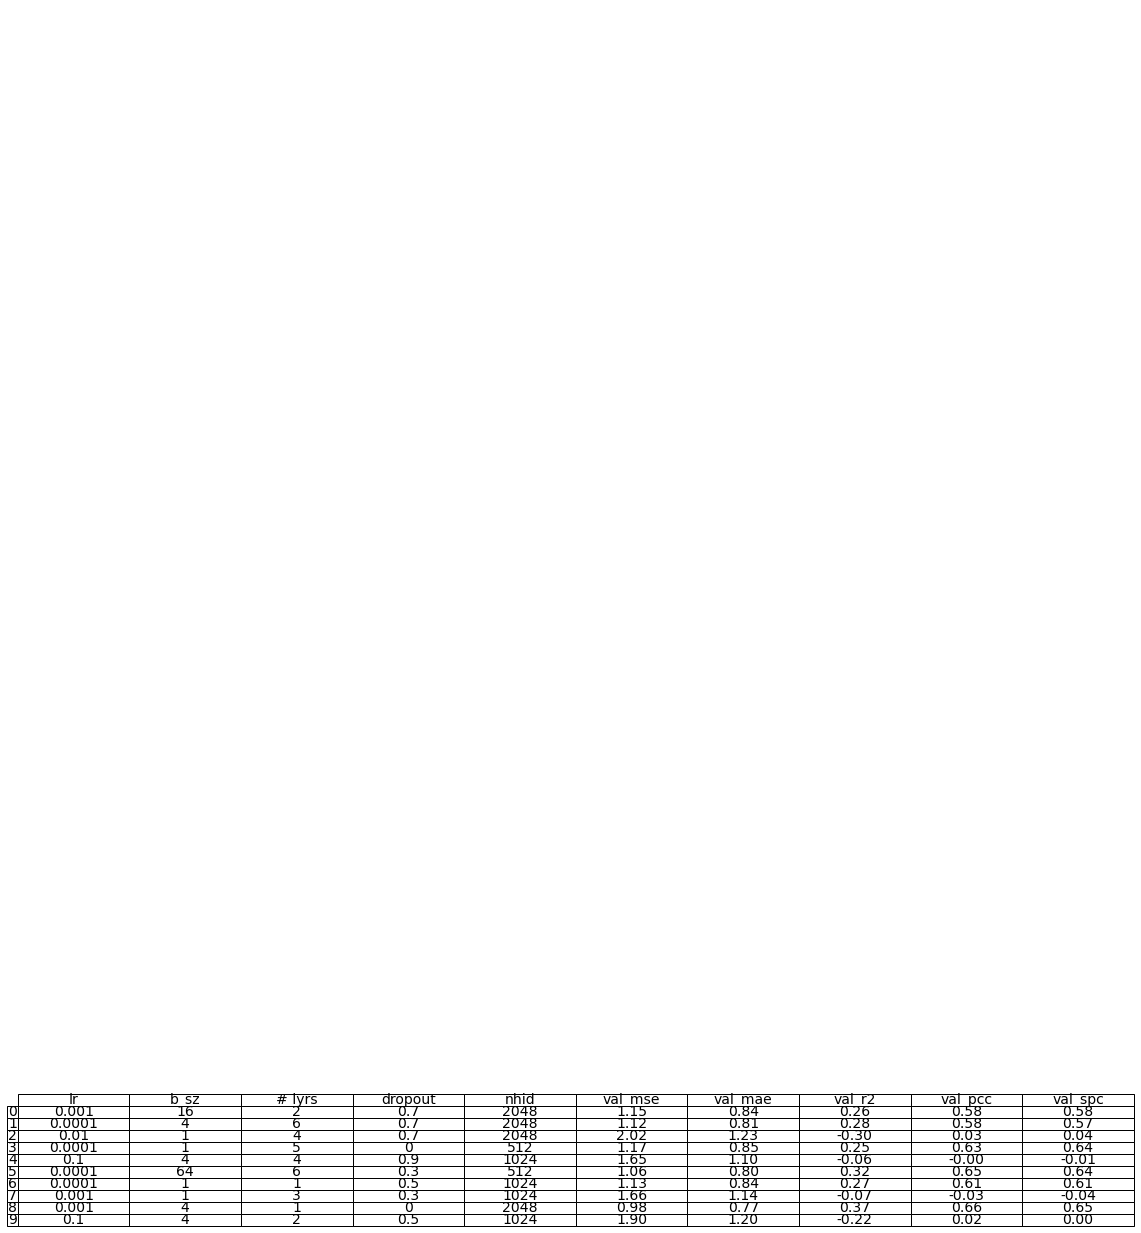

In [3]:
label_type = "gamma"
label_val  = 0
root_dir   = "Experiments/Table_1_Transformer_Tunning_Gamma"
dm         = FlyDataModule(cell_line="S2",
                          data_win_radius=5,
                          batch_size=1,
                          label_type=label_type,
                          label_val=label_val)
dm.setup()
vals=[]

exps = sorted(glob.glob(root_dir+"/optuna/*"))
for e, exp in enumerate(exps):
    layer_weights = glob.glob(exp+"/checkpoints/*")[0]
    hparams       = yaml.full_load(open(glob.glob(exp+"/hparams.yaml")[0]))
    model         = tr.TransformerModule.load_from_checkpoint(layer_weights).to("cuda:0")
    row           = []
    row.append(hparams['lr'])
    row.append(hparams['hparams']['batch_size'])
    row.append(hparams['nlayers'])
    row.append(hparams['dropout'])
    row.append(hparams['nhid'])
    mm            = ev.getModelMetrics(model, dm, 'val', clip_type="gamma").values()
    fmm           = list(map(lambda x: "{:.2f}".format(x), mm ))
    row.extend(fmm)
    vals.append(row)
cols = ['lr','b_sz', '# lyrs', 'dropout','nhid','val_mse','val_mae','val_r2','val_pcc','val_spc']
fig, ax = plt.subplots(1, figsize=(20,20))
table   = ax.table(vals,
                  cellLoc="center",
                  colLabels=cols,
                  rowLabels=list(range(0, len(exps))))
table.set_fontsize(14)
ax.axis('off')
plt.show()

Everything set
Experiments/Table_1_Transformer_Tunning_Gamma/optuna/version_5/checkpoints/epoch=33-step=2107.ckpt
init


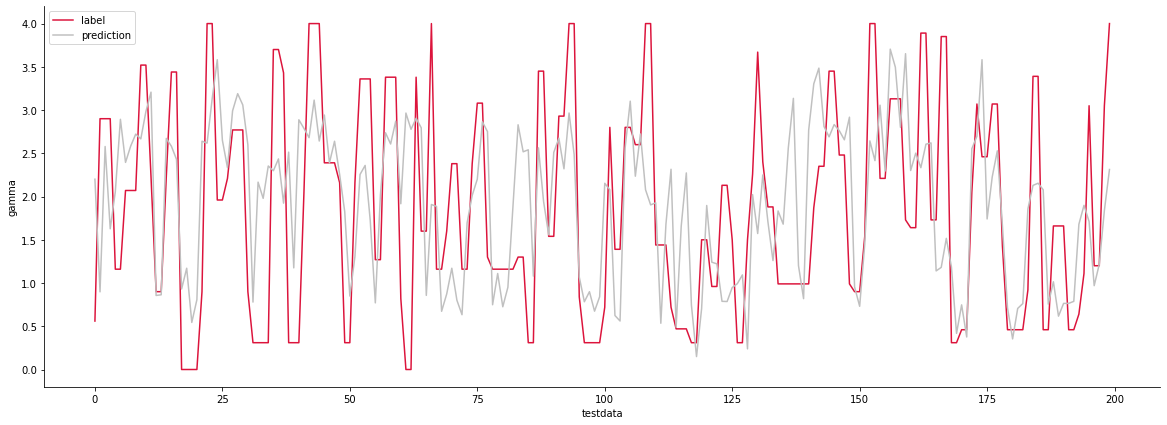

In [4]:
dm = FlyDataModule(cell_line="S2",
                  data_win_radius=5,
                  batch_size=1,
                  label_type="gamma",
                  label_val=10)
dm.setup()
layer_weights = glob.glob("Experiments/Table_1_Transformer_Tunning_Gamma/optuna/version_5/checkpoints/*")[0]
print(layer_weights)
model         = tr.TransformerModule.load_from_checkpoint(layer_weights).to("cuda:0")
ev.createPlot(model, dm, "test", "idk", clip_type="gamma")

In [4]:
#to csv
import pandas as pd
ar_val   = np.array(vals)
ar_col   = np.expand_dims(np.array(cols),0)
csv_data = np.vstack((ar_col, ar_val))
pd.DataFrame(csv_data).to_csv("Experiments/Table_1_Transformer_Tunning_Gamma/Sup_1_Results.csv")